# Hidden Markov Models' Applications

Because of HMMs' structure, they are very well suited for analyzing time series, as these data can be modeled as a [stochastic process](https://en.wikipedia.org/wiki/Stochastic_process). Some examples of these applications are in financial analysis ([example](https://www.mdpi.com/2227-7072/6/2/36)), expression and gesture analysis ([example](http://www.cs.umd.edu/~djacobs/CMSC828/ApplicationsHMMs.pdf)), and speech recognition. In this notebook, we will study how HMMs can be applied for speech recognition and introduce some useful automatic speech recognition (ASR) tools.

##### Contents:
- [Audio Signal Manipulation](#audio-signal-manipulation)
- [Speech Recognition Using HMMs](#speech-recognition-using-hmms)
    - [Feature Extraction](#feature-extraction)
    - [Phoneme Prediction and Decoding](#phoneme-pred-decode)
    - [Useful links](#links)

<a id="audio-signal-manipulation"></a>
## Audio Signal Manipulation

In order to understand a speech recognition system first we'll see how audio signals are stored digitally.

In [1]:
from IPython.display import Audio
from scipy.io.wavfile import read
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (24, 10)

To record an audio wave digitally, an audio device (e.g. a microphone) will sample the original sound wave periodically and record the wave's amplitude. The rate at which the device is recording the original wave is called the sampling rate and it should be at least twice the highest frequency in the audio wave ([Nyquist's rate](https://en.wikipedia.org/wiki/Nyquist%E2%80%93Shannon_sampling_theorem)). The recorded sound could also have multiple channels as well (for example, the left and right channel). Here we will use data from the [Free Spoken Digit Dataset (FSDD)](https://github.com/Jakobovski/free-spoken-digit-dataset) to visualize a few audio waves.

In [2]:
Fs, data2_1 = read('Audio/recordings_2_jackson_1.wav')
print(f'sampling rate: {Fs}')
print (f'speaker 1 audio shape: {data2_1.shape}')
Audio(data2_1, rate=Fs)

sampling rate: 8000
speaker 1 audio shape: (4424,)


In [3]:
Fs, data2_2 = read('Audio/recordings_2_george_29.wav')
print(f'sampling rate: {Fs}')
print (f'speaker 1 audio shape: {data2_2.shape}')
Audio(data2_2, rate=Fs)

sampling rate: 8000
speaker 1 audio shape: (3050,)


Here is the word "two", spoken by two different people. `scipy.io.wavfile.read` reads its input [.wav](https://en.wikipedia.org/wiki/WAV) file and returns two arguments: the audio file sampling rate and a numpy array containing the amplitude values. Here the dimentions of those arrays are $3050\times1$ and $4424\times1$ meaning the files contain a single channel audio wave with the duration of $\frac{3050}{8000} = 0.38$ and $\frac{4424}{8000} = 0.55$ seconds. 

In [4]:
Fs, data1 = read('Audio/recordings_1_jackson_10.wav')
Audio(data1, rate=Fs)

 Also included is the word "one" uttered by the first speaker. Now we plot the original waves and their [fourier transform](https://en.wikipedia.org/wiki/Discrete_Fourier_transform) to visualize the data and their patterns. 

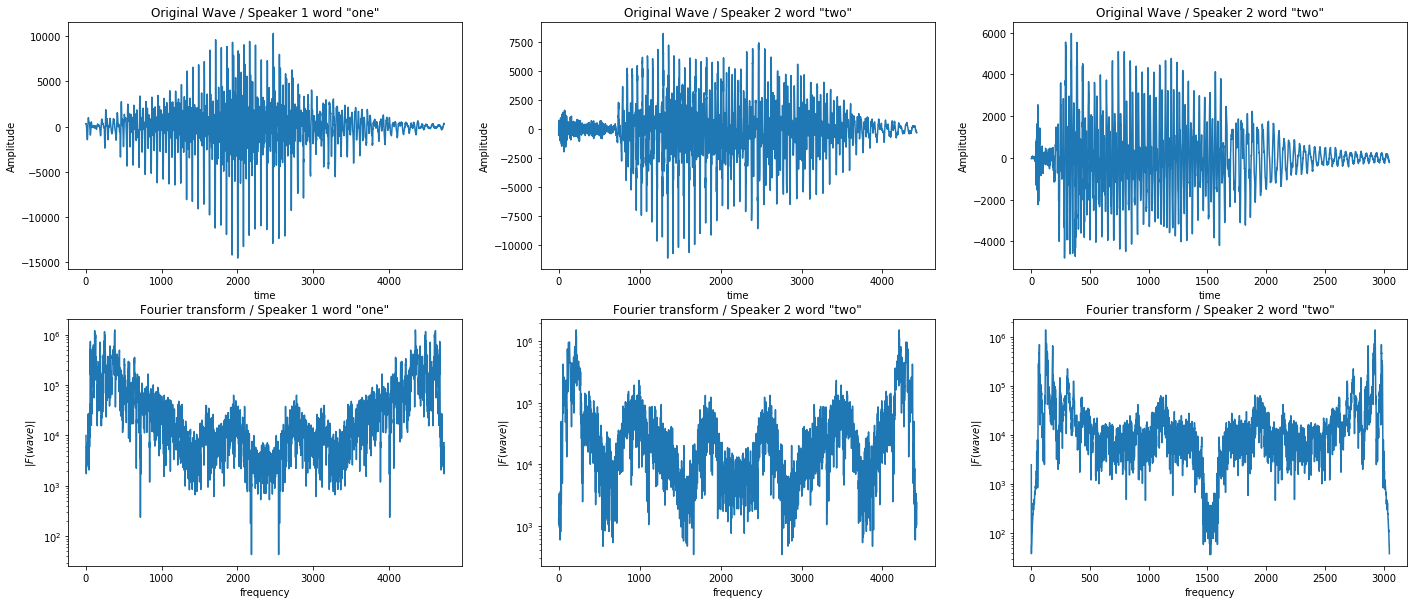

In [5]:
def plot_sound(data, axs, speaker, word):
    axs[0].plot(data)
    axs[0].set_ylabel('Amplitude')
    axs[0].set_xlabel('time')
    axs[0].set_title(f'Original Wave / Speaker {speaker} word "{word}"')
    axs[1].semilogy(np.abs(np.fft.fft(data)))
    axs[1].set_ylabel('$| F(wave)|$')
    axs[1].set_xlabel('frequency')
    axs[1].set_title(f'Fourier transform / Speaker {speaker} word "{word}"')
    

fig, axs = plt.subplots(nrows=2, ncols=3)

plot_sound(data1, axs[:,0], 1, 'one')
plot_sound(data2_1, axs[:,1], 2, 'two')
plot_sound(data2_2, axs[:,2], 2, 'two')

Another method of visualizing audio signals is the spectogram which plots the frequency distribution of sound over time:

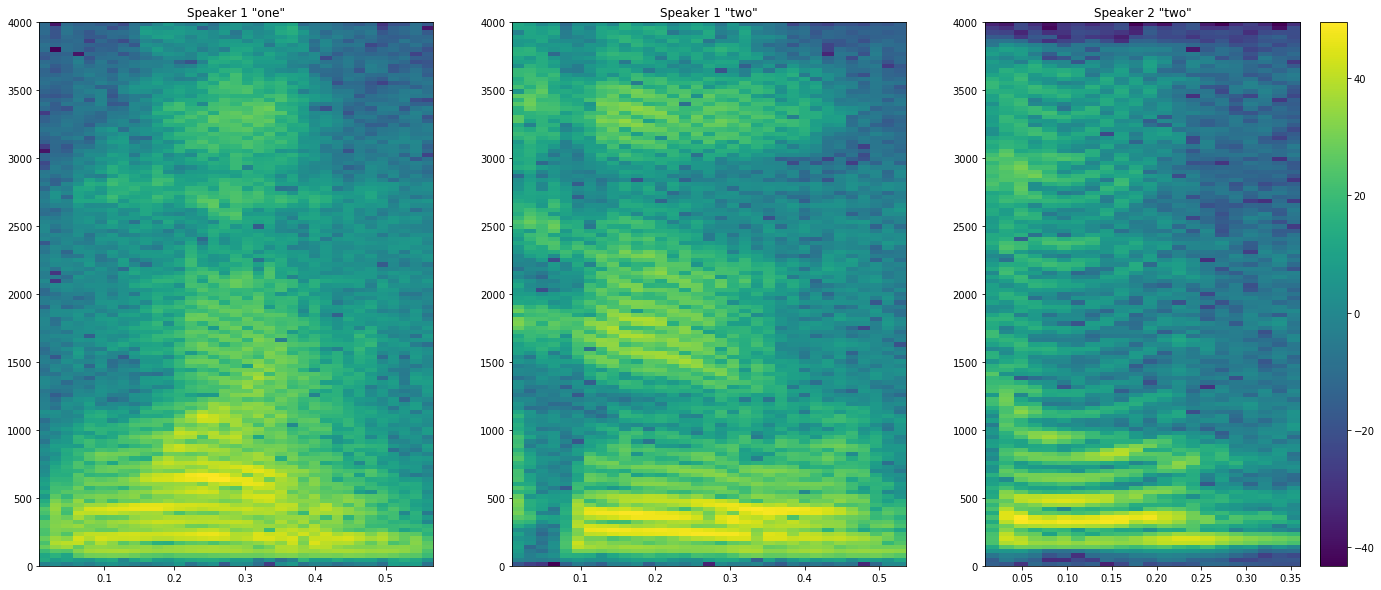

In [6]:
plt.subplot(1, 3, 1)
plt.title('Speaker 1 "one"')
Pxx, freqs, bins, im = plt.specgram(data1, Fs=Fs)
plt.subplot(1, 3, 2)
plt.title('Speaker 1 "two"')
Pxx, freqs, bins, im = plt.specgram(data2_1, Fs=Fs)
plt.subplot(1, 3, 3)
plt.title('Speaker 2 "two"')
Pxx, freqs, bins, im = plt.specgram(data2_2, Fs=Fs)
plt.colorbar()
plt.show()

<a id="speech-recognition-using-hmms"></a>
## Speech Recognition Using HMMs

Speech recognition is the task of converting spoken sounds to words (utterances). The general pipeline of an HMM-based ASR system consists of three stages:

<ol>
    <li>feature extraction from the audio signals</li>
    <li>phoneme prediction based on the extracted features</li>
    <li>Decoding the obtained phonemes to words</li>
</ol>

<a id="feature-extraction"></a>
### Feature Extraction

In this step, the goal is to extract features that represent the data best and have the least amount of noise possible. Some widely used descriptors are:
- [MFCC](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum) and [CMVN](https://en.wikipedia.org/wiki/Cepstral_mean_and_variance_normalization) that are closely related to the fourier transform and the spectrogram.
- [i-vectors](http://people.csail.mit.edu/sshum/talks/ivector_tutorial_interspeech_27Aug2011.pdf) that vary mostly with the speaker and are well-suited for speaker recognition.

The MFCCs of the previously spoken numbers are calculated below using **Kaldi**. [Kaldi](http://kaldi-asr.org/) is a powerful tool for speech recognition that interfaces with the user using shell scripts. In order to use Kaldi via Python, a wrapper called [Pykaldi](https://github.com/pykaldi/pykaldi) can be installed through conda or direct compilation.

In [90]:
from kaldi.feat.mfcc import Mfcc, MfccOptions
from kaldi.matrix import SubVector, SubMatrix, Matrix, Vector
from sklearn.preprocessing import scale
import seaborn as sns

In [91]:
mfcc_opts = MfccOptions()
mfcc_opts.frame_opts.samp_freq = Fs
mfcc = Mfcc(mfcc_opts)
mfcc_opts.frame_opts.samp_freq

8000.0

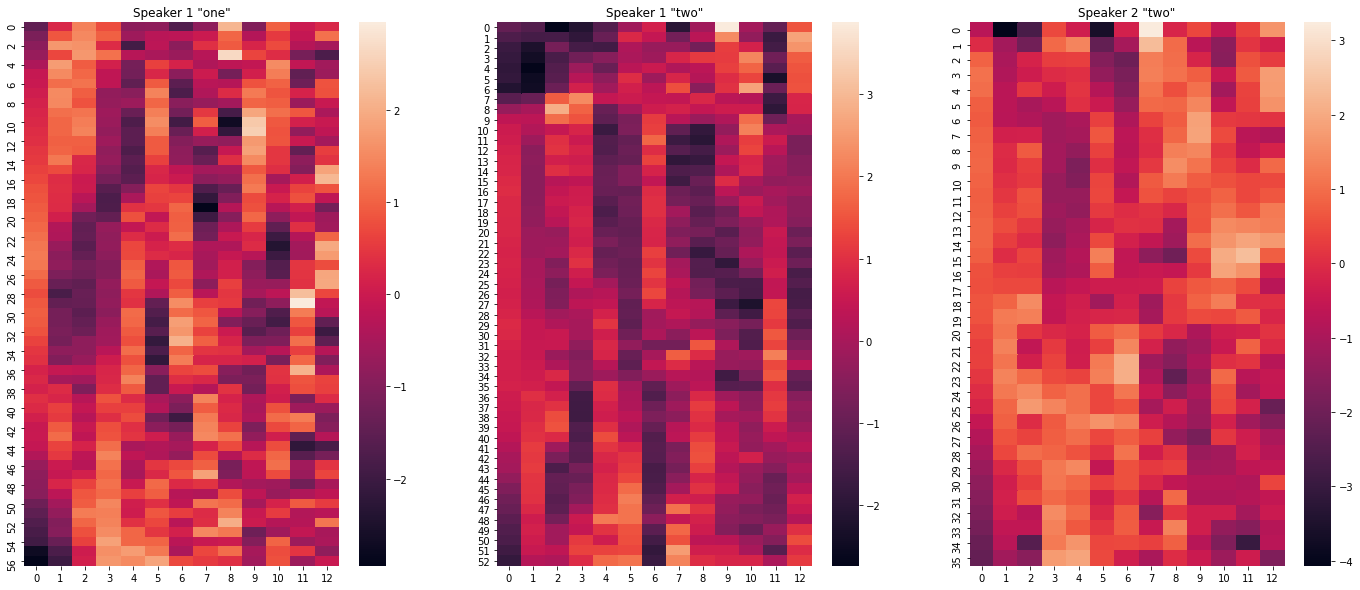

In [92]:
def plot_mfcc(data, ax, speaker, word):
    feats = mfcc.compute(Vector(data), 1.0)
    sns.heatmap(scale(feats), ax=ax)
    ax.set_title(f'Speaker {speaker} "{word}"')

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)
plot_mfcc(data1, ax1, 1, 'one')
plot_mfcc(data2_1, ax2, 1, 'two')  
plot_mfcc(data2_2, ax3, 2, 'two')

<a id="phoneme-pred-decode"></a>
### Phoneme Prediction and Decoding
In the next step, an HMM transforms the sequence of features into *phonemes*. Phonemes are the basic and smallest unit of sound in a language. In Kaldi, the structure of such HMM can be set using a topology file. [Here](http://kaldi-asr.org/doc/hmm.html) is the documentation page for HMM models in Kaldi.

Afterward, the phonemes are decoded into words using weighted finite state machines (WFSMs) - or in general, **decoding graphs** - in which the weights represent the phoneme probabilities. For more information on how FSMs can be used in ASR, see this [paper](https://cs.nyu.edu/~mohri/pub/hbka.pdf). Generally, converting a set of features to a word is equivalent to maximizing the probability of the word given the data:
$$
\hat{w} = \underset{w}{\mathrm{argmax}}{P\left(w\mid \mathbf{x}\right)} = \underset{w}{\mathrm{argmax}}{P\left( \mathbf{x}\mid w\right)P(w)}
$$
where $\mathbf{x}$ is the input features and $\hat{w}$ is the predicted word. The first term $P\left( \mathbf{x}\mid w\right)$ comes from the *acoustic model* and the second term $P(w)$ comes from the *language model*. Since each word consists of multiple phonemes and has different pronunciations, the first term can be written as:
$$
P\left( \mathbf{x}\mid w\right) = \sum_{Q}P\left( \mathbf{x}\mid Q\right)P\left(Q\mid w\right)
$$
where $Q$ is the set of different pronunciations of a word. 

In order to train an HMM ASR model, Kaldi needs a text file mapping each word to their respective phonemes called a *dictionary*. for more information on Kaldi's training process, check the [docs](http://kaldi-asr.org/doc).

So in conclusion, an HMM-based speech recognition system first converts the audio wave to a set of feature descriptors and then uses those descriptors to calculate the probability distribution over the possible phonemes. Finally, the phonemes are used to calculate the most probable word using decoding graphs.

<a id="links"></a>
***some useful links:***
- [A detailed survey on the applications of HMMs in ASR](https://mi.eng.cam.ac.uk/~mjfg/mjfg_NOW.pdf)
- [A quick overview on the general process of speech recognition and Kaldi](https://towardsdatascience.com/how-to-start-with-kaldi-and-speech-recognition-a9b7670ffff6)
- [Lecture slides on speech recognition with Kaldi](http://www.danielpovey.com/kaldi-lectures.html)
- [Audio Signal Processing for Machine Learning](https://youtube.com/playlist?list=PL-wATfeyAMNqIee7cH3q1bh4QJFAaeNv0)